In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import time

In [2]:
data = pd.read_excel("../Dataset.xlsx", sheet_name=['Total Consumers'])
df = data['Total Consumers']
number_of_houses = len(df.columns)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


## Auxiliary functions

In [3]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mse)
    #wmape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    #mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
    mape = mae / actuals.mean()  
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print('MSE: %.4f' % mse)
    print('RMSE: %.4f' % rmse)
    print('MAE: %.4f' % mae)
    print('MAPE: %.4f' % (mape * 100))
    print('R2: %.4f' % r2)
    return mse, rmse, mae, mape, r2

def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    return model, preds

In [4]:
def total_averaged_metrics(metrics_list):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged RMSE: {}".format(np.round(sum(j for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAE: {}".format(np.round(sum(k for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAPE: {}".format(np.round(sum(l for i, j, k, l, m in metrics_list)*100/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(m for i, j, k, l, m in metrics_list)/len(metrics_list),3)))

def predict_results(X_train, X_test, y_train, y_test):
    model, preds = build_model(LinearRegression(), X_train, y_train, X_test)
    mse, rmse, mae, mape, r2 = performance_metrics(preds, y_test.values.reshape(-1))
    return mse, rmse, mae, mape, r2

def split_train_test(X, y, train_size: int):
    n_train_samples = int(len(X) * train_size)
    X_train = X[:n_train_samples]
    X_test = X[n_train_samples:]
    y_train = y[:n_train_samples]
    y_test = y[n_train_samples:]
    return X_train, X_test, y_train, y_test

def last_energy_points(df, number_timesteps):
    X_total = pd.DataFrame()
    for i in range(1, (number_timesteps + 1) ):
        X_total[f'Energy_{i}'] = df.shift(i)
    X_total.dropna(inplace=True)
    X_total.reset_index(drop=True, inplace=True)
    y_total = pd.DataFrame(df[number_timesteps:])
    y_total.reset_index(drop=True, inplace=True)
    y_total.columns = ["Energy"]
    return X_total, y_total

def prepare_polynomial(X, y, deg):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    poly_features = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = split_train_test(poly_features, y, train_size=0.8)
    return X_train, X_test, y_train, y_test

In [5]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,58.514142
1,57.575249
2,63.011688
3,62.735722
4,63.404029
...,...
35131,49.211311
35132,43.139892
35133,44.599341
35134,28.956084


### Normalize data

In [6]:
#values = df_total.values
#scaler = MinMaxScaler()
#df_scaled = scaler.fit_transform(values)
#df_total = pd.DataFrame(df_scaled)
#df_total.columns = ['Energy']
#df_total

# Linear Regression

## Test for last 3 hours

In [7]:
metrics_list = []
full_start = time.time()
for i in range(1,13):
    start = time.time()
    print("\nIteration ", i)
    X, y = last_energy_points(df_total, i)

    X_train, X_test, y_train, y_test = split_train_test(X, y, 0.8)

    mse, rmse, mae, mape, r2 = predict_results(X_train, X_test, y_train, y_test)
    metrics_list.append((mse,rmse,mae,mape,r2))
    print("\nElapsed time: {} seconds".format(np.round(time.time() - start),3))
print("\nFull Elapsed time: {} seconds".format(np.round(time.time() - full_start),3))


Iteration  1
MSE: 144.5524
RMSE: 12.0230
MAE: 8.3762
MAPE: 18.1854
R2: 0.7406

Elapsed time: 0.0 seconds

Iteration  2
MSE: 144.2977
RMSE: 12.0124
MAE: 8.3711
MAPE: 18.1744
R2: 0.7411

Elapsed time: 0.0 seconds

Iteration  3
MSE: 141.1126
RMSE: 11.8791
MAE: 8.2858
MAPE: 17.9893
R2: 0.7468

Elapsed time: 0.0 seconds

Iteration  4
MSE: 140.7325
RMSE: 11.8631
MAE: 8.2809
MAPE: 17.9786
R2: 0.7475

Elapsed time: 0.0 seconds

Iteration  5
MSE: 139.3523
RMSE: 11.8048
MAE: 8.2572
MAPE: 17.9270
R2: 0.7499

Elapsed time: 0.0 seconds

Iteration  6
MSE: 139.2407
RMSE: 11.8000
MAE: 8.2539
MAPE: 17.9208
R2: 0.7502

Elapsed time: 0.0 seconds

Iteration  7
MSE: 139.4716
RMSE: 11.8098
MAE: 8.2623
MAPE: 17.9391
R2: 0.7497

Elapsed time: 0.0 seconds

Iteration  8
MSE: 139.5374
RMSE: 11.8126
MAE: 8.2641
MAPE: 17.9428
R2: 0.7496

Elapsed time: 0.0 seconds

Iteration  9
MSE: 139.3947
RMSE: 11.8066
MAE: 8.2614
MAPE: 17.9371
R2: 0.7499

Elapsed time: 0.0 seconds

Iteration  10
MSE: 139.4473
RMSE: 11.8088
MAE

In [11]:
mse_list = []
rmse_list = []
mae_list = []
mape_list = []
r2_list = []

for i in range(0,12):
    mse_list.append(metrics_list[i][0])
    rmse_list.append(metrics_list[i][1])
    mae_list.append(metrics_list[i][2])
    mape_list.append(metrics_list[i][3] * 100)
    r2_list.append(metrics_list[i][4])

## Plot performance metrics

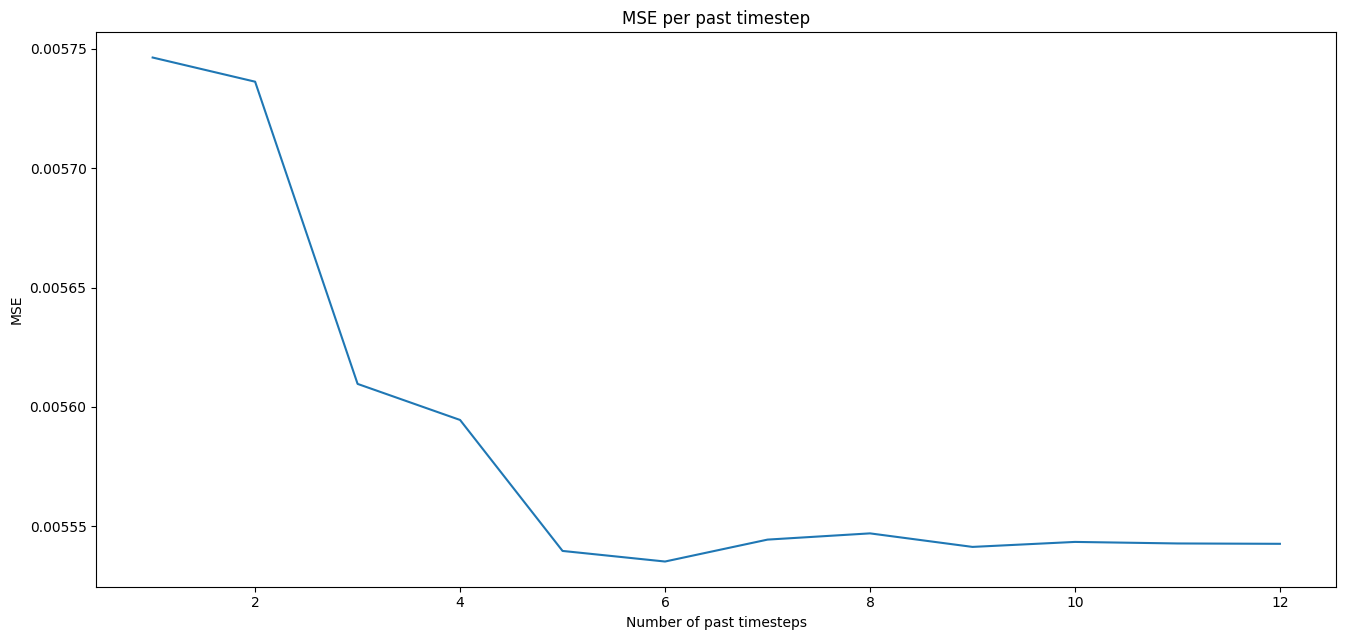

In [12]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), mse_list)
plt.title('MSE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('MSE')
plt.show()

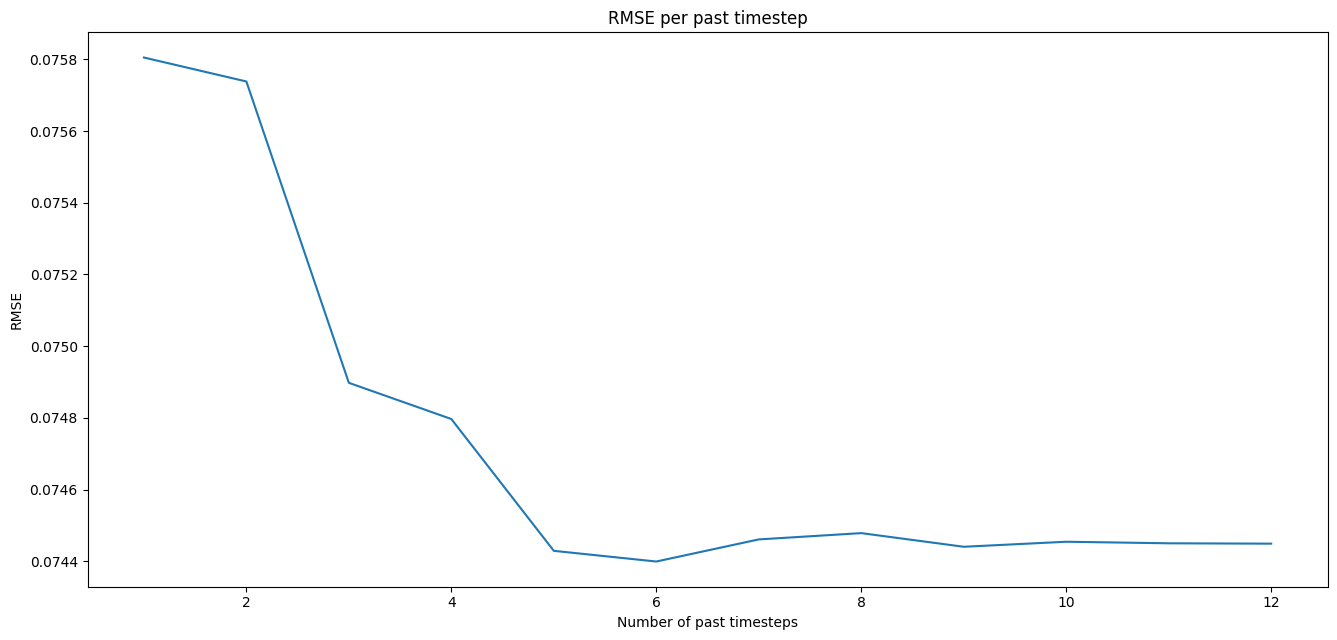

In [13]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), rmse_list)
plt.title('RMSE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('RMSE')
plt.show()

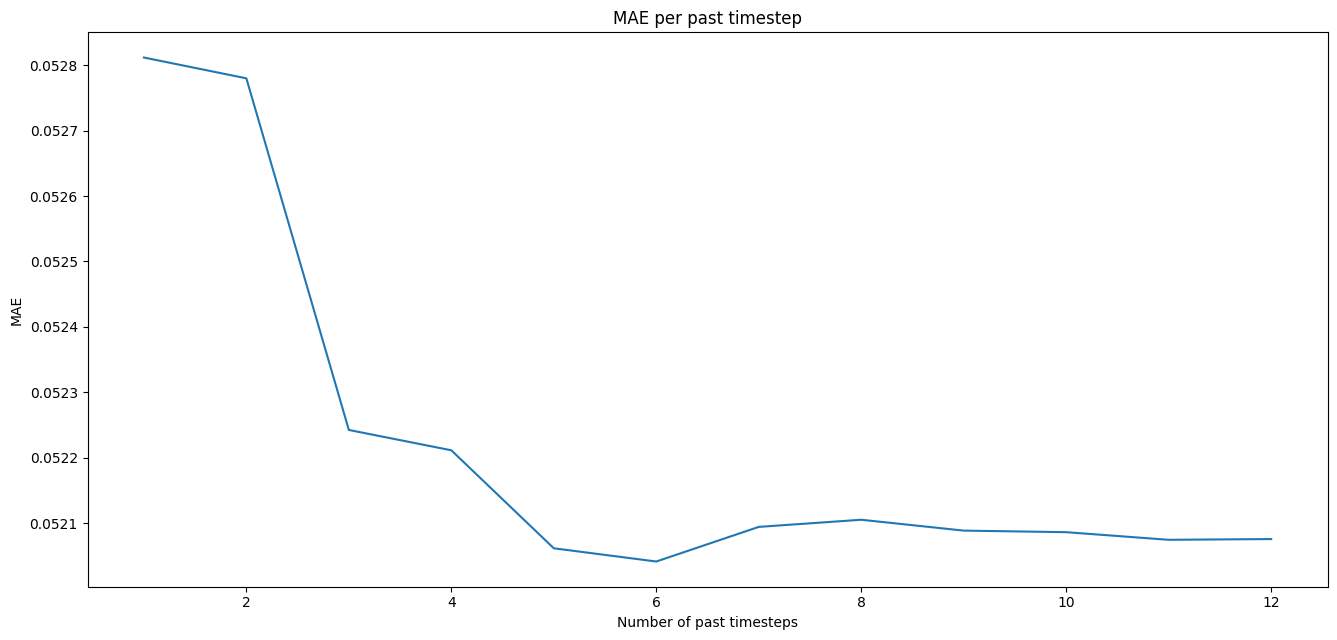

In [14]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), mae_list)
plt.title('MAE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('MAE')
plt.show()

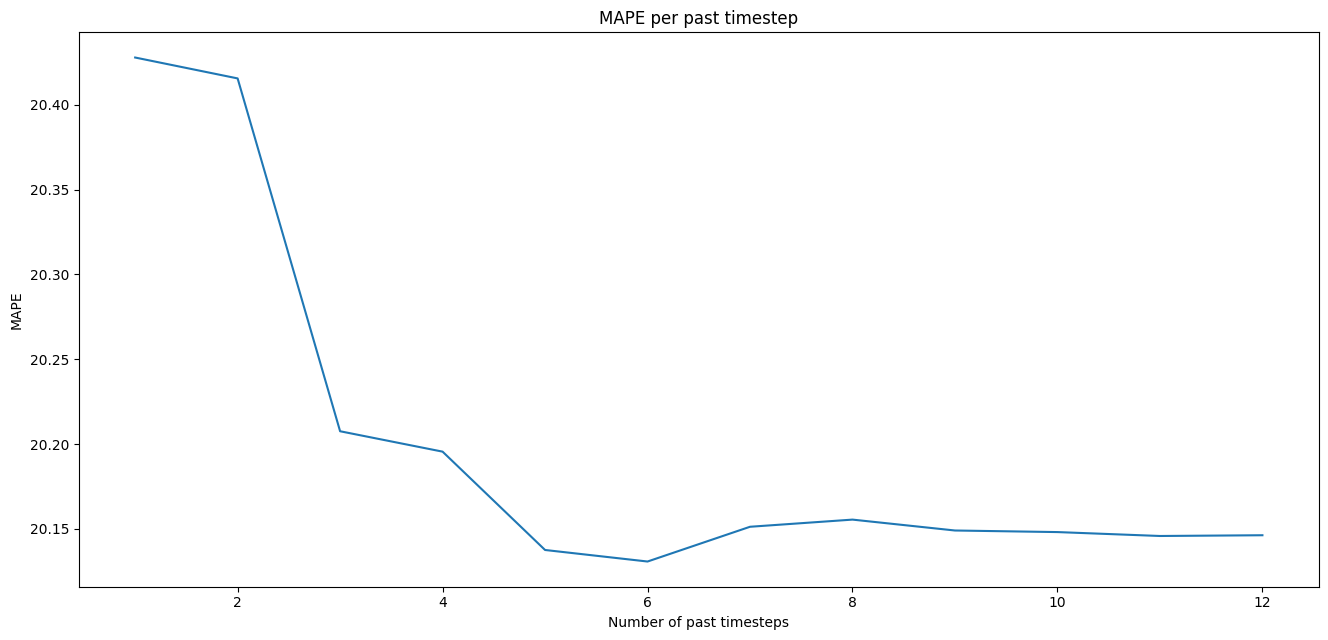

In [15]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), mape_list)
plt.title('MAPE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('MAPE')
plt.show()

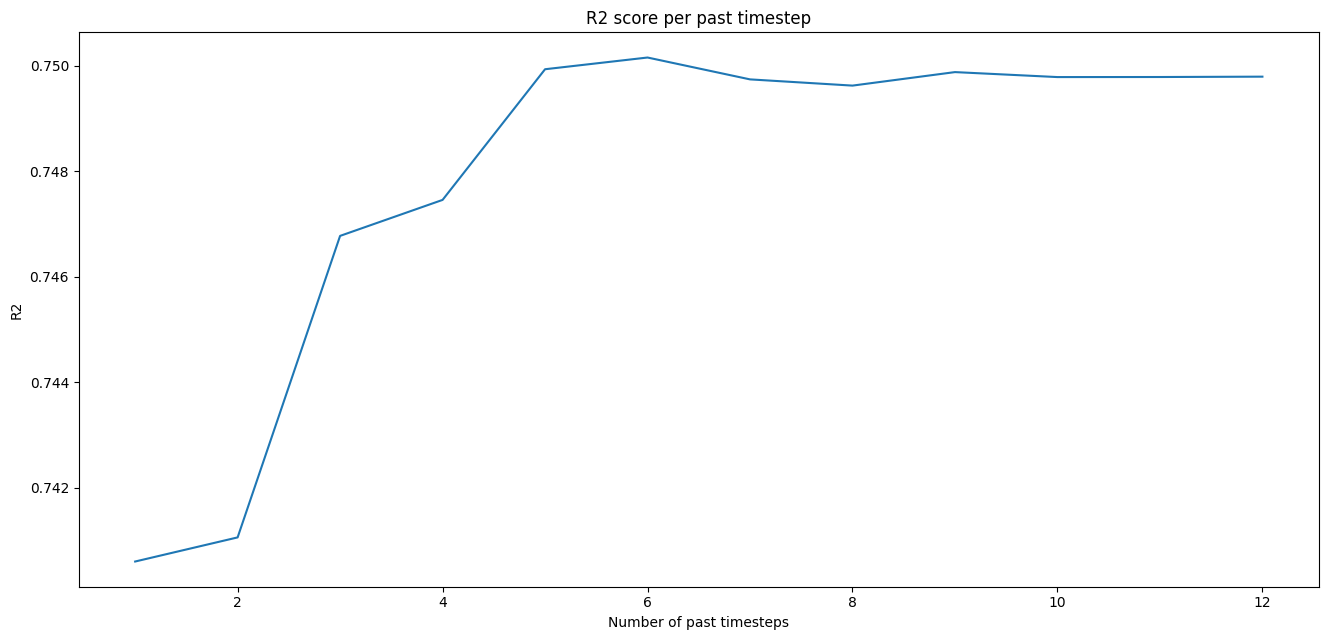

In [16]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,13), r2_list)
plt.title('R2 score per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('R2')
plt.show()

# Polynomial Regression

### Test for last 12 energy points (3 hours) degree 2, 3 and 4

In [17]:
degree_list = []
full_start = time.time()
for degree in range(2,5):
    metrics_list = []
    print("\n\t\tDegree ", degree)
    for i in range(1,13):
        start = time.time()
        print("\nIteration ", i)
        X, y = last_energy_points(df_total, i)
        X_train, X_test, y_train, y_test = prepare_polynomial(X, y, deg=degree)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        mse, rmse, mae, mape, r2 = predict_results(X_train, X_test, y_train, y_test)
        print()
        metrics_list.append((mse,rmse,mae,mape,r2))      
        print("\nElapsed time: {} seconds".format(np.round(time.time() - start),3))
    degree_list.append(metrics_list)
print("\nFull Elapsed time: {} seconds".format(np.round(time.time() - full_start),3))


		Degree  2

Iteration  1
(28108, 2) (7027, 2) (28108, 1) (7027, 1)
MSE: 0.0058
RMSE: 0.0760
MAE: 0.0527
MAPE: 20.3905
R2: 0.7396


Elapsed time: 0.0 seconds

Iteration  2
(28107, 5) (7027, 5) (28107, 1) (7027, 1)
MSE: 0.0058
RMSE: 0.0759
MAE: 0.0526
MAPE: 20.3570
R2: 0.7400


Elapsed time: 0.0 seconds

Iteration  3
(28106, 9) (7027, 9) (28106, 1) (7027, 1)
MSE: 0.0056
RMSE: 0.0748
MAE: 0.0519
MAPE: 20.0885
R2: 0.7474


Elapsed time: 0.0 seconds

Iteration  4
(28105, 14) (7027, 14) (28105, 1) (7027, 1)
MSE: 0.0056
RMSE: 0.0747
MAE: 0.0519
MAPE: 20.0810
R2: 0.7479


Elapsed time: 0.0 seconds

Iteration  5
(28104, 20) (7027, 20) (28104, 1) (7027, 1)
MSE: 0.0055
RMSE: 0.0744
MAE: 0.0518
MAPE: 20.0393
R2: 0.7503


Elapsed time: 0.0 seconds

Iteration  6
(28104, 27) (7026, 27) (28104, 1) (7026, 1)
MSE: 0.0055
RMSE: 0.0744
MAE: 0.0518
MAPE: 20.0422
R2: 0.7502


Elapsed time: 0.0 seconds

Iteration  7
(28103, 35) (7026, 35) (28103, 1) (7026, 1)
MSE: 0.0055
RMSE: 0.0744
MAE: 0.0518
MAPE: 20.0

In [18]:
p_mse_list = []
p_rmse_list = []
p_mae_list = []
p_mape_list = []
p_r2_list = []

for j in range(0,3):
    mse_l = []
    rmse_l = []
    mae_l = []
    mape_l = []
    r2_l = []
    
    for i in range(0,12):
        mse_l.append(degree_list[j][i][0])
        rmse_l.append(degree_list[j][i][1])
        mae_l.append(degree_list[j][i][2])
        mape_l.append(degree_list[j][i][3] * 100)
        r2_l.append(degree_list[j][i][4])
    p_mse_list.append(mse_l)
    p_rmse_list.append(rmse_l)
    p_mae_list.append(mae_l)
    p_mape_list.append(mape_l)
    p_r2_list.append(r2_l)

## Comparison between Linear and Polynomial

Text(0, 0.5, 'MSE')

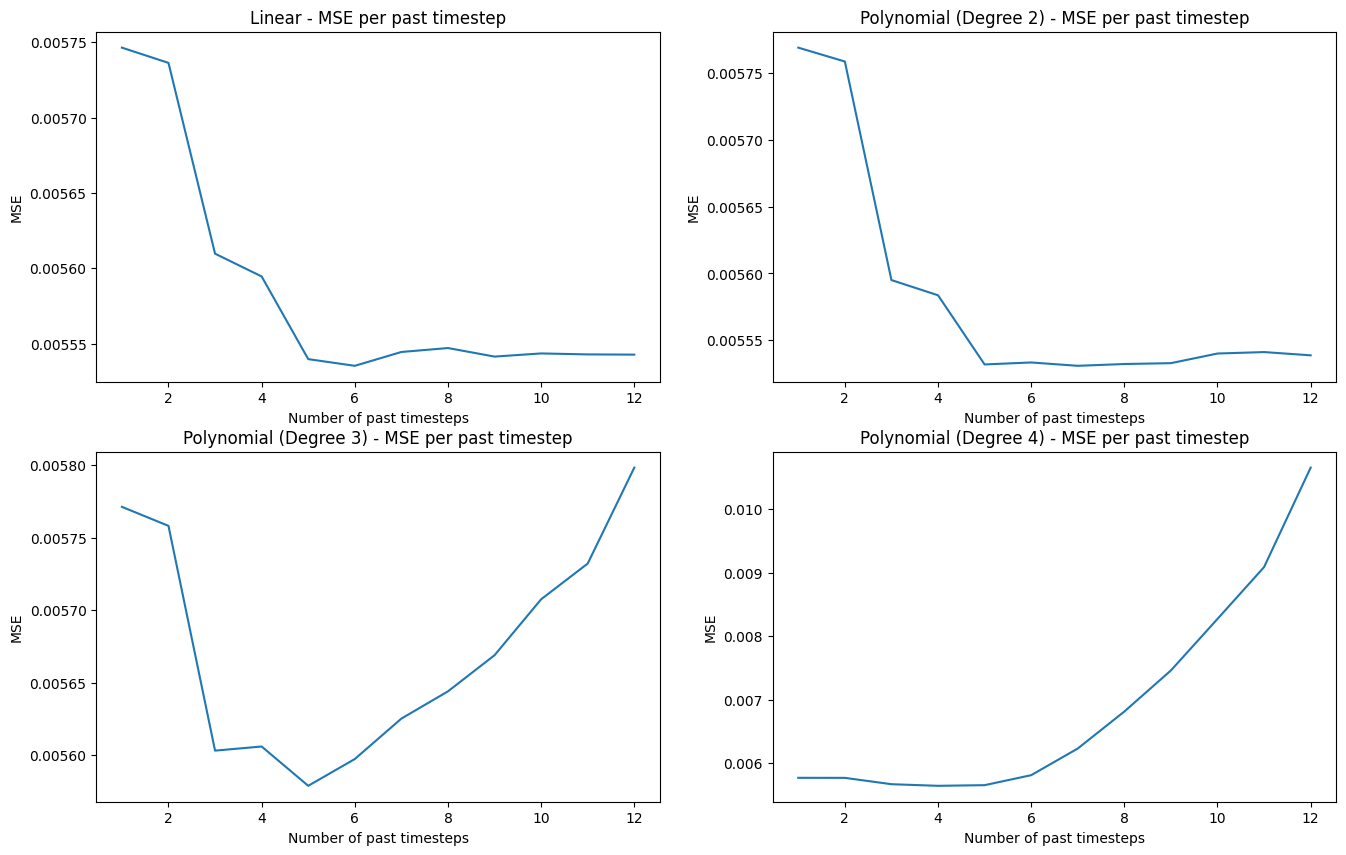

In [19]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), mse_list)
axis[0,0].set_title("Linear - MSE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("MSE")
  
axis[0,1].plot(range(1,13), p_mse_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - MSE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("MSE")

axis[1,0].plot(range(1,13), p_mse_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - MSE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("MSE")

axis[1,1].plot(range(1,13), p_mse_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - MSE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("MSE")

Text(0, 0.5, 'RMSE')

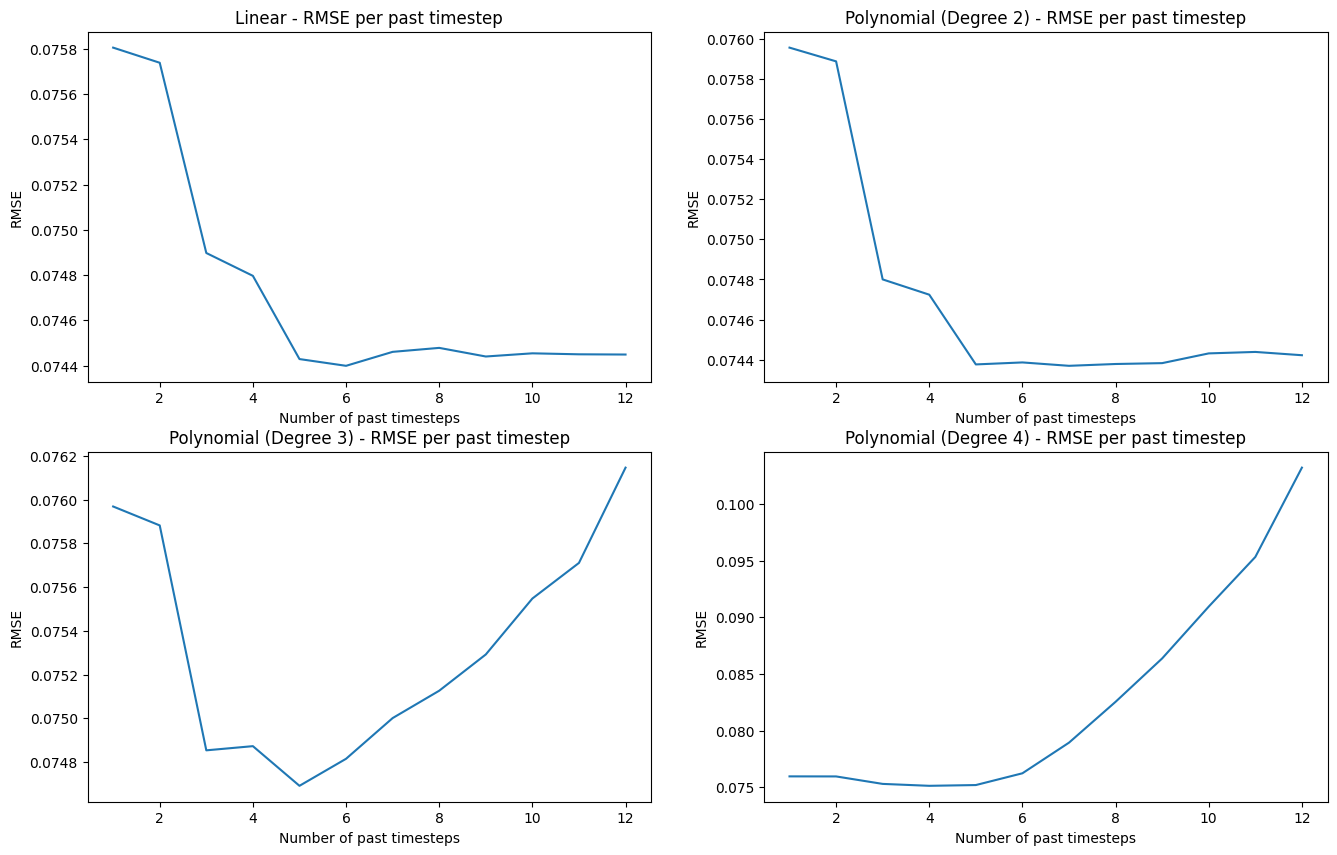

In [20]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), rmse_list)
axis[0,0].set_title("Linear - RMSE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("RMSE")
  
axis[0,1].plot(range(1,13), p_rmse_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - RMSE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("RMSE")

axis[1,0].plot(range(1,13), p_rmse_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - RMSE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("RMSE")

axis[1,1].plot(range(1,13), p_rmse_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - RMSE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("RMSE")

Text(0, 0.5, 'MAE')

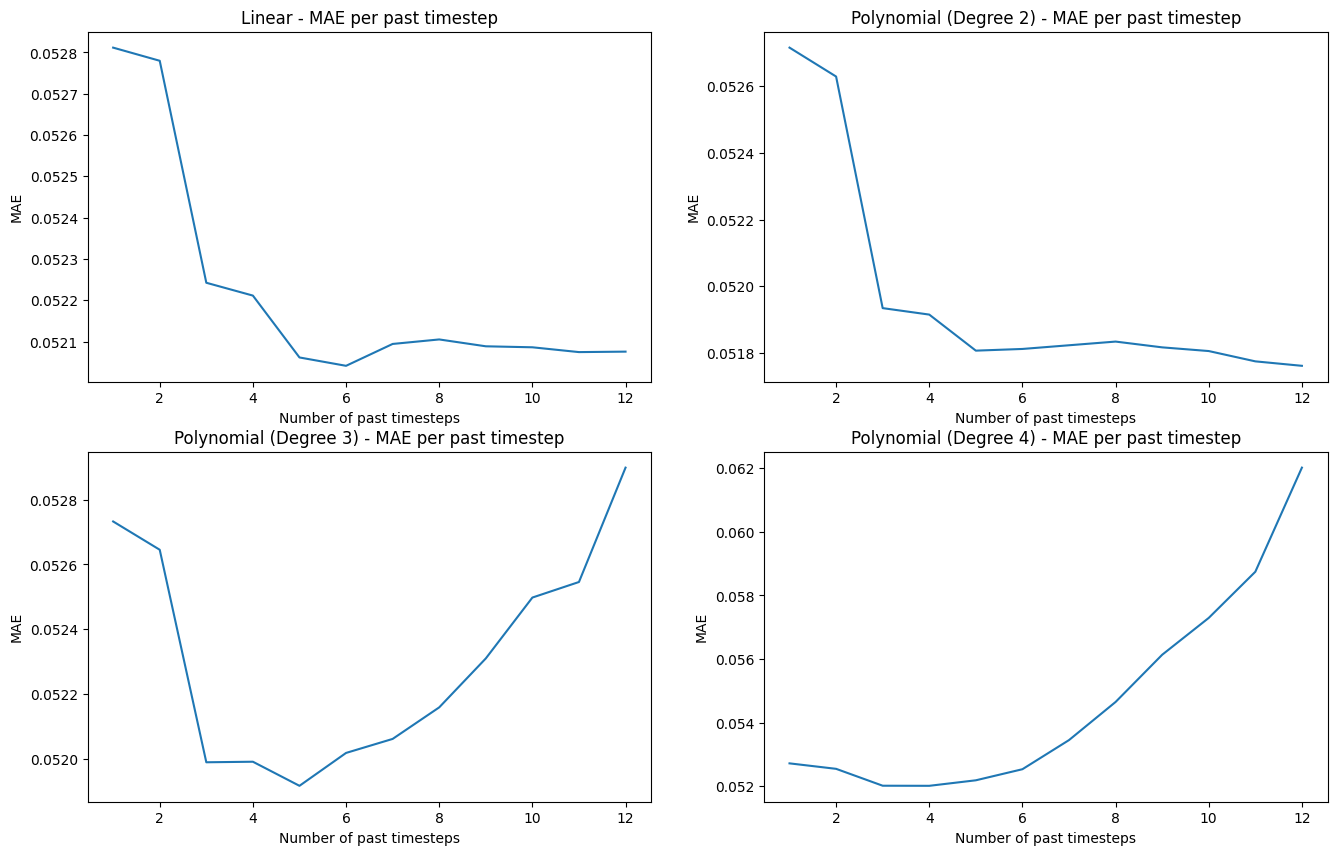

In [21]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), mae_list)
axis[0,0].set_title("Linear - MAE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("MAE")
  
axis[0,1].plot(range(1,13), p_mae_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - MAE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("MAE")

axis[1,0].plot(range(1,13), p_mae_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - MAE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("MAE")

axis[1,1].plot(range(1,13), p_mae_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - MAE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("MAE")

Text(0, 0.5, 'MAPE')

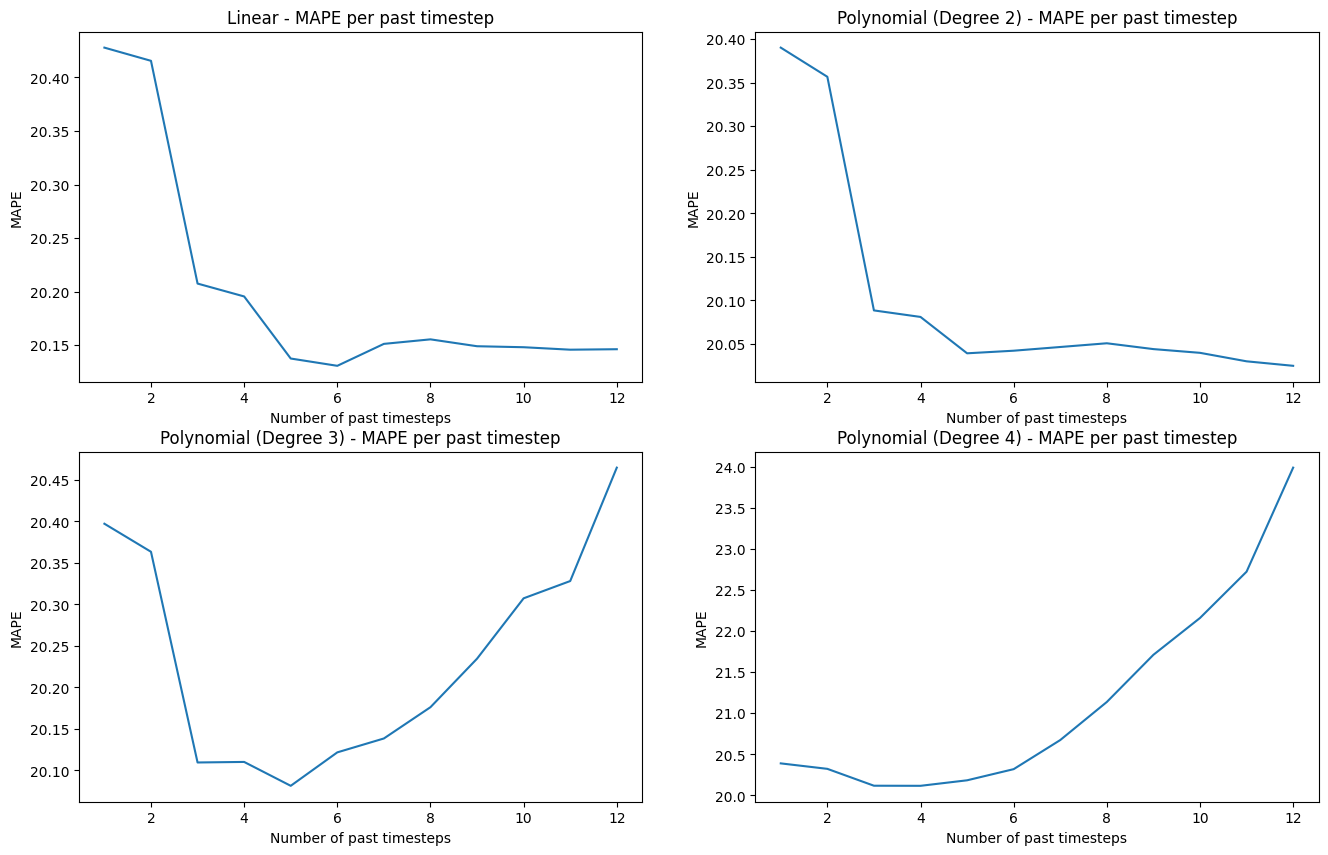

In [22]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), mape_list)
axis[0,0].set_title("Linear - MAPE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("MAPE")
  
axis[0,1].plot(range(1,13), p_mape_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - MAPE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("MAPE")

axis[1,0].plot(range(1,13), p_mape_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - MAPE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("MAPE")

axis[1,1].plot(range(1,13), p_mape_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - MAPE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("MAPE")

Text(0, 0.5, 'R2 score')

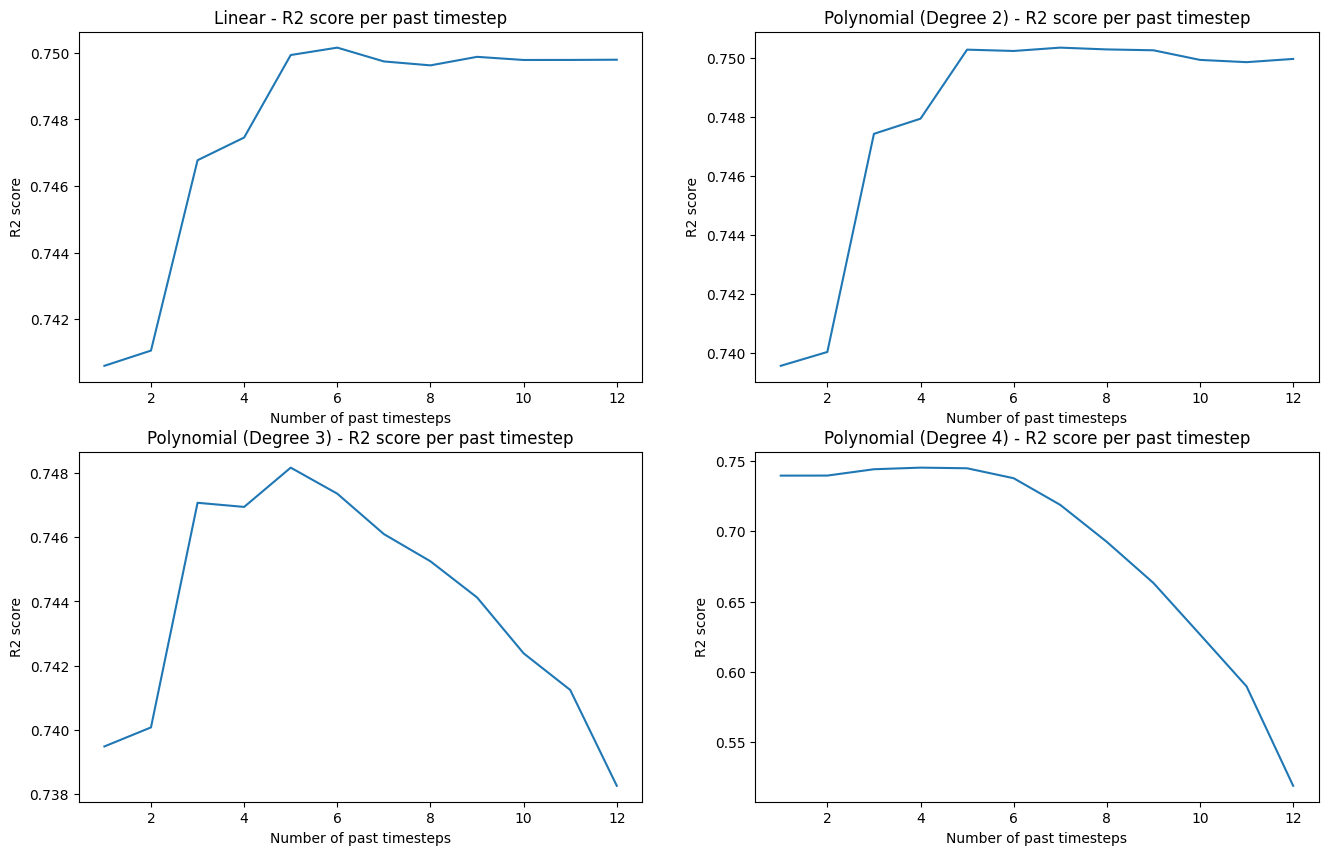

In [23]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,13), r2_list)
axis[0,0].set_title("Linear - R2 score per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("R2 score")
  
axis[0,1].plot(range(1,13), p_r2_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - R2 score per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("R2 score")

axis[1,0].plot(range(1,13), p_r2_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - R2 score per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("R2 score")

axis[1,1].plot(range(1,13), p_r2_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - R2 score per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("R2 score")